## Application of `Geoplanar`


### Example US and Canada

### Fixing Overlays 

In this notebook, we will demonstrate some of the basic functionality of `geoplanar` using the example of a researcher interested in integrating data from the United States and Canada, to study the US-Canada international border region. 

#### Steps
1. Data Retrieval
2. Testing for overlays
3. Fixing overlays
3. Saving Data


In [5]:
import geoplanar
import geopandas as gpd
import numpy as np

In [6]:
import warnings
warnings.filterwarnings("ignore")

### 1. Data Retrieval US/Canada Level 1 Data

In [7]:
uscan = gpd.read_parquet("../../geoplanar/datasets/uscan/gaps_removed.parquet")
uscan.head()

,level_0,geometry,COUNTRY,index,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS,...,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
0,59,"POLYGON ((-89.56835 47.99815, -89.53059 48.001...",LAKE,NaN,NaN,NaN,NaN,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
1,64,"POLYGON ((-82.92947 42.36300, -82.87499 42.458...",LAKE,NaN,NaN,NaN,NaN,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
2,63,"POLYGON ((-82.46070 42.90598, -82.46270 42.895...",LAKE,NaN,NaN,NaN,NaN,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
3,0,"MULTIPOLYGON (((-122.40075 48.22540, -122.4615...",US,0.0,20.750,34.956,1.0,1.0,Washington,53,...,None,None,None,None,None,None,None,None,None,None
4,1,"POLYGON ((-111.47463 44.70224, -111.48001 44.6...",US,1.0,45.132,34.527,2.0,2.0,Montana,30,...,None,None,None,None,None,None,None,None,None,None


In [8]:
uscan.columns

Index(['level_0', 'geometry', 'COUNTRY', 'index', 'AREA', 'PERIMETER',
       'STATE_', 'STATE_ID', 'STATE_NAME', 'STATE_FIPS', 'SUB_REGION',
       'STATE_ABBR', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'VARNAME_1',
       'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1'],
      dtype='object')

<AxesSubplot:>

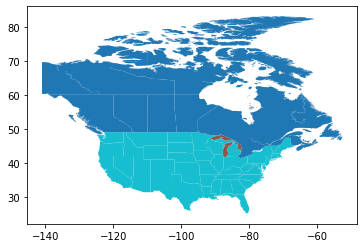

In [9]:
uscan.plot(column="COUNTRY")

In [10]:
uscan.shape

(64, 22)

In [11]:
a =geoplanar.gaps(uscan)

In [12]:
a.shape

(0, 1)

In [13]:
geoplanar.is_planar_enforced(uscan)

False

This dataset used here is not planar enforced.

### 2.  Border Discrepancies

Since US and Canada shapefiles were collected from different data sources there can be a possibility of planar enforcement violations. For now, we are going to zoom in on a subset of the border region to investigate things further:

In [14]:
from shapely.geometry import box

clipper = gpd.GeoDataFrame(geometry =[box(-110, 38, -65, 54)])

In [15]:
grouped = uscan.groupby(uscan.COUNTRY)

In [16]:
can = grouped.get_group("CANADA")
us = grouped.get_group("US")
lakes = grouped.get_group("LAKE")

In [17]:
usborder = gpd.clip(us, clipper)
canborder = gpd.clip(can, clipper)

In [18]:
border = usborder.append(canborder)

<AxesSubplot:>

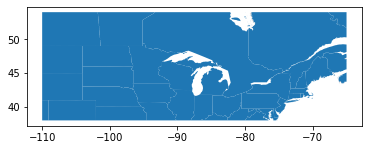

In [19]:
border.plot()

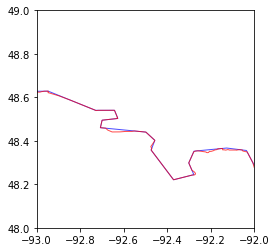

In [20]:
base = usborder.plot(alpha=0.7, facecolor='none', edgecolor='blue')
_ = canborder.plot(alpha=0.7, facecolor='none', edgecolor='red', ax=base)
_ = base.set_xlim(-93, -92)
_ = base.set_ylim(48, 49)


The red line is Canada's border and the blue line represent US border, if you look closely the two lines are not perfectly aligned. There are some overlaps that can potentially lead to planar enforcement violations.

To test if we have any planar enforcement violations we can apply the `geoplanar` package on the two countries data. Here we will test it on the bordering regions.

### 3. Testing for Overlaps

In [21]:
geoplanar.is_overlapping(uscan)

True

We can use geoplanar to identify if the data has issues of overlaps and overshoots.

### 4. Fixing Overlaps/Overshoots

In [22]:
uscan.area # area before applying geoplanar

0      15.543974
1       0.058636
2       0.000533
3      20.749831
4      45.131677
         ...    
59    137.462838
60      0.670316
61    206.218829
62     90.424490
63     87.600875
Length: 64, dtype: float64

In [23]:
uscan.area.sum() # sum of area for all the polygons before geoplanat

2527.2310769884657

In [24]:
overlaps_removed = geoplanar.trim_overlaps(uscan, largest=False) #changing the default


In [25]:
overlaps_removed_default = geoplanar.trim_overlaps(uscan) # default 


#### Changes in area after application of geoplanar

In [26]:
overlaps_removed.area.sum()  # checking area for default after geoplanar

2527.203542029223

In [27]:
overlaps_removed_default.area.sum()  # checking area after geoplanar

2527.2035420292177

Here we see minor changes in the total areas of the two countries combined dataset.
Furthermore, we can test to check if the overlaps are removed in the new data:

In [28]:
geoplanar.is_overlapping(overlaps_removed)

False

In [29]:
geoplanar.is_overlapping(overlaps_removed_default)

False

### 5. Identifying Undershoots/Gaps

Trimming the overlaps removes the areas where points belong to both national polygons. Since we separately solved the issue of gaps, ideally one of these setting should give us the gaps =0. That data can be saved for further analysis.

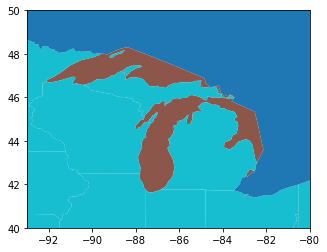

In [30]:
base = overlaps_removed.plot(column='COUNTRY')
_ = base.set_xlim(-93, -80)
_ = base.set_ylim(40, 50)

In [31]:
gaps=geoplanar.gaps(overlaps_removed)

In [32]:
gaps.shape

(38, 1)

In [33]:
gaps.total_bounds

array([-119.00018311,   42.32083511,  -67.41911316,   49.38045502])

In [34]:
g=gaps.buffer(0.5)

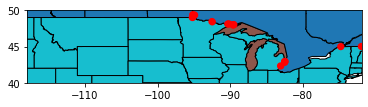

In [35]:
base = overlaps_removed.plot(column='COUNTRY', edgecolor='k')
g.plot(ax=base, color='red')
_ = base.set_xlim(-118, -71.85)
_ = base.set_ylim(40, 50)

In [36]:
gaps_2=geoplanar.gaps(overlaps_removed_default)

In [37]:
gaps_2.shape

(38, 1)

In [38]:
g2=gaps_2.buffer(0.5)

In [39]:
gaps_2.total_bounds

array([-117.03097534,   42.79268646,  -67.30102539,   49.        ])

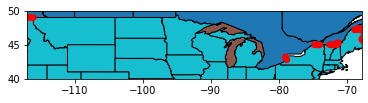

In [40]:
base = overlaps_removed_default.plot(column='COUNTRY', edgecolor='k')
g2.plot(ax=base, color='red')
_ = base.set_xlim(-117, -67.85)
_ = base.set_ylim(40, 50)

The default setting gives us data that has zero gaps.

In [41]:
geoplanar.is_planar_enforced(overlaps_removed_default)

False

In the example above we still encounter additional gaps due to fixing the overlays.

### 6. New Data to get Zero Gaps

In [42]:
uscan_2 = gpd.read_parquet("../../geoplanar/datasets/uscan/gaps_removed_nondefault.parquet")
uscan_2.head()

,level_0,geometry,COUNTRY,index,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS,...,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
0,59,"POLYGON ((-89.56835 47.99815, -89.53059 48.001...",LAKE,NaN,NaN,NaN,NaN,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
1,64,"POLYGON ((-82.92947 42.36300, -82.87499 42.458...",LAKE,NaN,NaN,NaN,NaN,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
2,63,"POLYGON ((-82.46070 42.90598, -82.46270 42.895...",LAKE,NaN,NaN,NaN,NaN,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
3,0,"MULTIPOLYGON (((-122.45316 48.12867, -122.3600...",US,0.0,20.750,34.956,1.0,1.0,Washington,53,...,None,None,None,None,None,None,None,None,None,None
4,1,"POLYGON ((-111.45990 44.67010, -111.45747 44.6...",US,1.0,45.132,34.527,2.0,2.0,Montana,30,...,None,None,None,None,None,None,None,None,None,None


In [43]:
OR_default = geoplanar.trim_overlaps(uscan_2) 

In [44]:
gaps_3=geoplanar.gaps(OR_default)

In [45]:
gaps_3.shape

(0, 1)

In [46]:
geoplanar.is_planar_enforced(OR_default)

True

### Saving Data after fixing problems

In [47]:
OR_default.to_parquet("../../geoplanar/datasets/uscan/planar_enforced.parquet")